In [4]:
from ClassiPyGRB import SWIFT
# Packages needed for this notebook
import os
import numpy as np

In [5]:
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [12]:
%matplotlib inline
swift = SWIFT(root_path=r'data', res=64, n_bands=[1,2,3,4,5])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV', '15-350keV']


In [13]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_Noise_Reduced_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
grb_names, features = data_loaded['names'], data_loaded['data']
durations = swift.total_durations(grb_names, t=90)

Finding Durations: 100%|██████████████████| 1513/1513 [00:08<00:00, 187.71GRB/s]


In [14]:
features.shape

(1513, 48000)

In [11]:
features[0]

array([3.27656018e-04, 8.90758136e-05, 1.61375288e-04, ...,
       1.73956208e-07, 1.70693101e-07, 2.93644213e-08])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


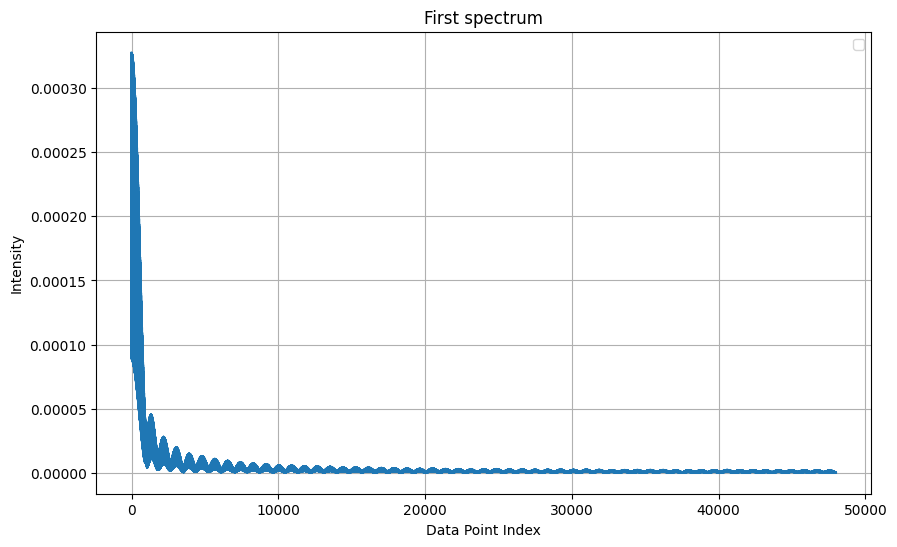

In [17]:
x = np.linspace(0, features.shape[1], features.shape[1])  # Simulated x-axis values for the spectrum

plt.figure(figsize=(10, 6))
plt.plot(x, features[0])
plt.title('First spectrum')
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
print(np.mean(features,axis=1))
print(np.std(features,axis=1))

[3.93423877e-06 2.51062688e-06 6.09117290e-06 ... 8.28946402e-07
 9.82905208e-06 1.85110271e-06]
[1.80824322e-05 1.44391144e-05 1.99728055e-05 ... 8.67291283e-06
 2.74094220e-05 1.15974967e-05]


In [20]:
# Normalize the features here
normalized_features = (features - np.mean(features, axis=1, keepdims=1))/np.std(features,axis=1,keepdims=1)
print(normalized_features.shape)
print(np.mean(normalized_features,axis=1))
print(np.std(normalized_features,axis=1))

(1502, 48000)
[-1.89478063e-17  1.42108547e-17  2.84217094e-17 ...  3.55271368e-17
  1.42108547e-17  3.78956126e-17]
[1. 1. 1. ... 1. 1. 1.]


In [21]:
_normalized_features = normalized_features # copy this so rerunning next cell doesn't throw error
_labels = np.zeros(shape=(normalized_features.shape[0],1))

In [22]:
normalized_features = torch.from_numpy(_normalized_features).to(torch.float32)
labels = torch.from_numpy(_labels).to(torch.float32)

X_train, X_test, class_train, class_test = train_test_split(normalized_features, labels, test_size=0.2, random_state=205)

training_dataset = TensorDataset(X_train, class_train)
test_dataset = TensorDataset(X_test, class_test)

BATCHSIZE = 128
BATCHSIZE_TEST = 256

train_dataloader = DataLoader(training_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCHSIZE_TEST, shuffle=True)

In [23]:
INPUT_SIZE      = features.shape[1]
LATENT_SIZE     = 5
HIDDEN_SIZE     = 100

In [24]:
# Note that this code is largely from https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/tree/main/Sessions/Session14
# First, we will inherit from pytorch Module class; https://pytorch.org/docs/stable/generated/torch.nn.Module.html

class Encoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # here we are initializing the linear layers. This registeres the layer parameters (W,b) as parameters of the Module
        self.fc1 = nn.Linear(INPUT_SIZE,HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE,LATENT_SIZE)

        # We will initialize weights following a multivariate Gaussian
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)

    # this defines a forward pass of the network (="applying" the network to some input data)
    def forward(self, x):
        # print(x.dtype)
        # print(self.fc1.weight.dtype)
        # print(self.fc1.bias.dtype) # for debugging dtype mismatch
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        z      = self.fc2(x)
        return z

class Decoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Using the encoder, how will you initialize two layers?
        self.fc1 = nn.Linear(LATENT_SIZE,HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE,INPUT_SIZE)

        # Using the endoer, how will you initialize the weights and biases?
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)

    def forward(self, z):
        # Using the encoder, how will you define the forward pass?
        # I recommend the same activation function!
        z      = torch.nn.LeakyReLU()(self.fc1(z))
        x      = self.fc2(z)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # here we are creating instances of the Encoder and Decoder class
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [25]:
# This creates an instance of the Autoencoder class
AE = Autoencoder()

In [26]:
# the training loop takes a function that loads the data batch by batch, a model to train, a loss function to train the model on and an optimizer
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    # iterate over the dataset
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction of the model
        pred = model(X)
        # Compute the loss function
        loss = loss_fn(pred,X)

        # Backpropagation; this is where we take the gradient and update the network parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # here we keep track of the loss
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return losses

# the test loop is similar to the training loop, only that we don't take any gradients/don't update the network parameters, but only evaluate
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss =  0
    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f" Avg test loss: {test_loss:>8f} \n")

    return test_loss

In [27]:
EPOCHS = 200
LEARNING_RATE = 1e-3


# MeanSquaredError (L2) Loss
loss_fn         = nn.MSELoss()
# Adam Optimizer
optimizer       = torch.optim.Adam(AE.parameters(), lr=LEARNING_RATE)


train_loss = []
test_loss  = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, AE, loss_fn, optimizer))
    test_loss.append(test_loop(test_dataloader, AE, loss_fn))
print("Done!")

Epoch 1
-------------------------------
train loss: 1.000079  [    0/ 1201]
 Avg test loss: 0.831940 

Epoch 2
-------------------------------
train loss: 0.848528  [    0/ 1201]
 Avg test loss: 0.526300 

Epoch 3
-------------------------------
train loss: 0.549767  [    0/ 1201]
 Avg test loss: 0.344603 

Epoch 4
-------------------------------
train loss: 0.337102  [    0/ 1201]
 Avg test loss: 0.265719 

Epoch 5
-------------------------------
train loss: 0.271848  [    0/ 1201]
 Avg test loss: 0.194619 

Epoch 6
-------------------------------
train loss: 0.189656  [    0/ 1201]
 Avg test loss: 0.169142 

Epoch 7
-------------------------------
train loss: 0.167746  [    0/ 1201]
 Avg test loss: 0.140066 

Epoch 8
-------------------------------
train loss: 0.141405  [    0/ 1201]
 Avg test loss: 0.146535 

Epoch 9
-------------------------------
train loss: 0.131780  [    0/ 1201]
 Avg test loss: 0.123897 

Epoch 10
-------------------------------
train loss: 0.130024  [    0/ 12

In [28]:
plot_train_loss = [x[-1] for x in train_loss]

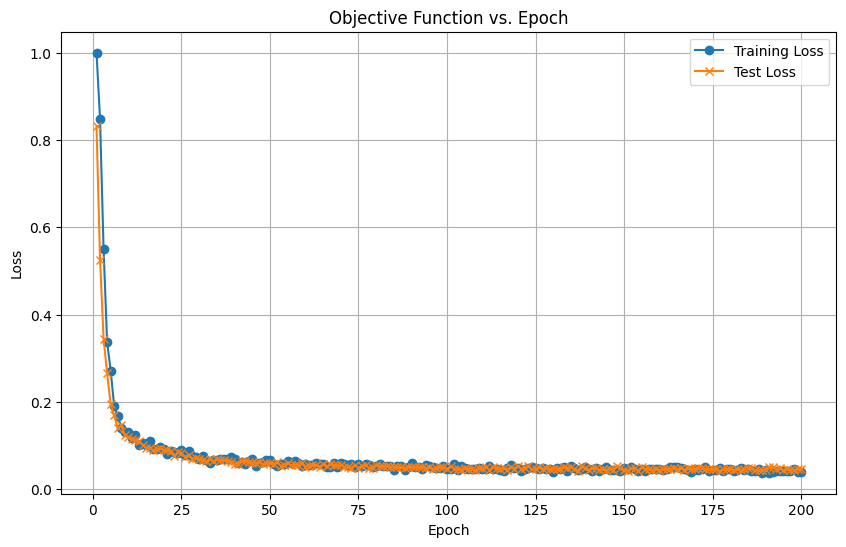

In [29]:
epochs = range(1, len(train_loss) + 1)  # Epochs are 1-based indexing

plt.figure(figsize=(10, 6))
plt.plot(epochs, plot_train_loss, label='Training Loss', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', marker='x')
plt.title('Objective Function vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

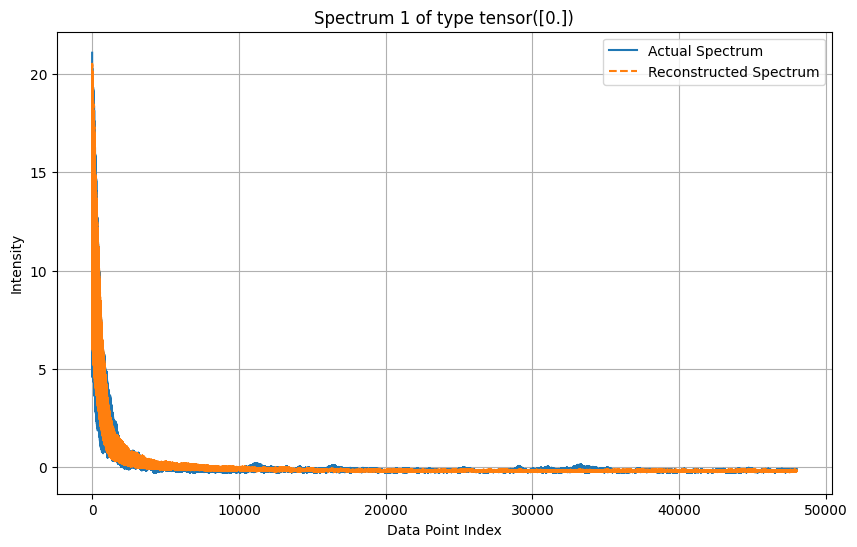

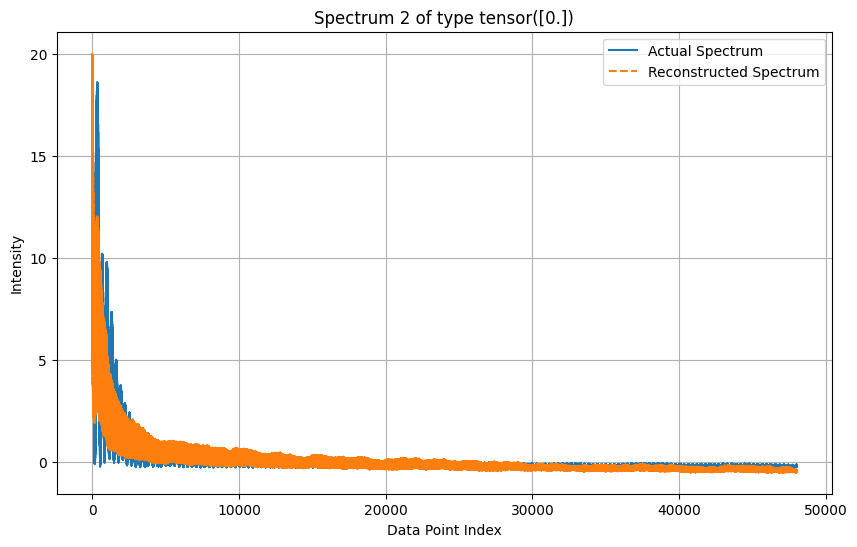

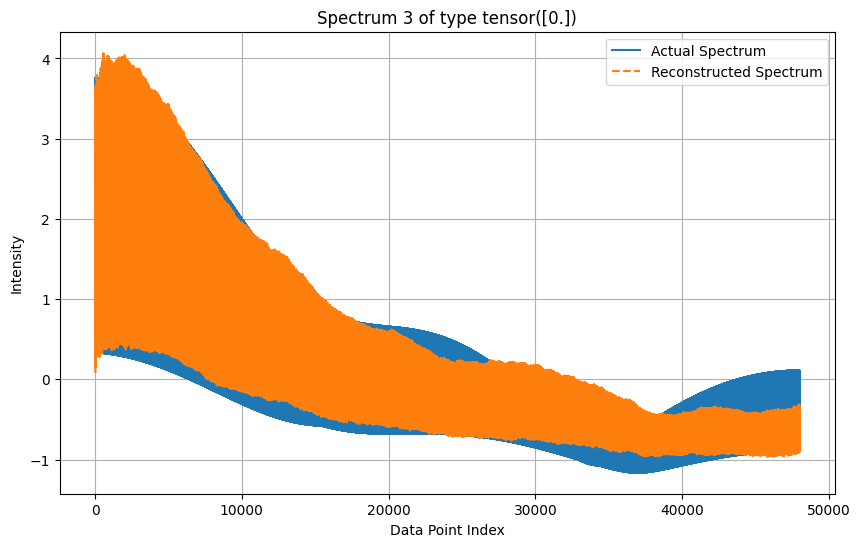

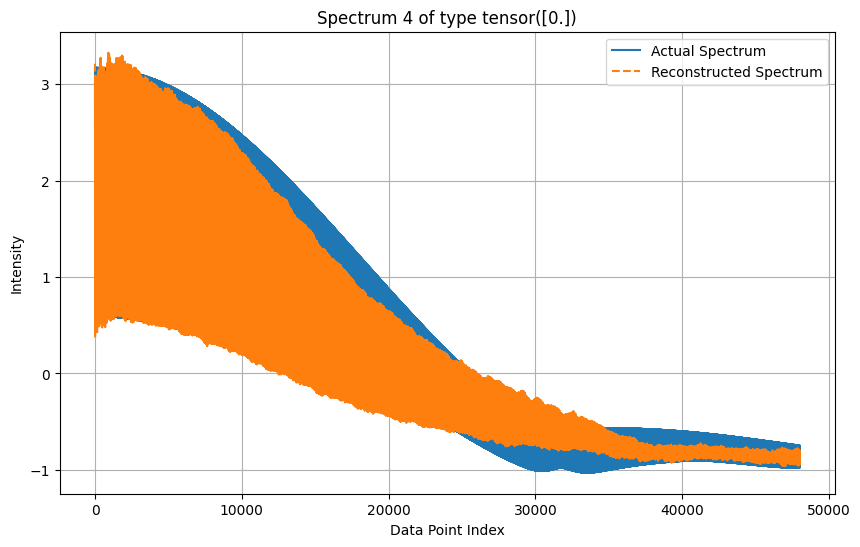

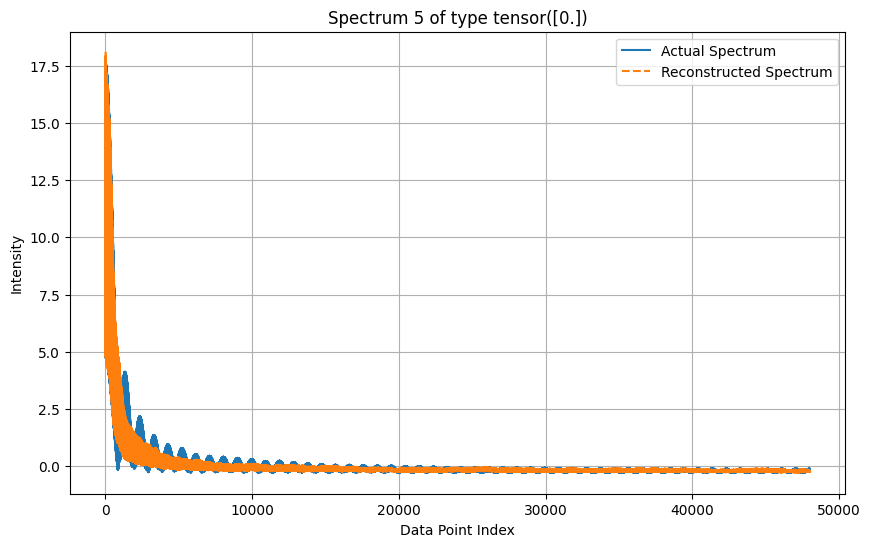

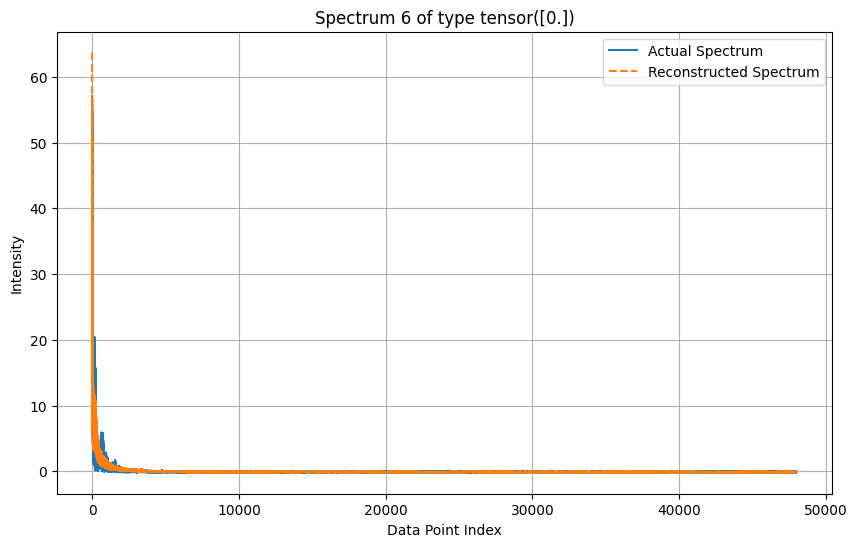

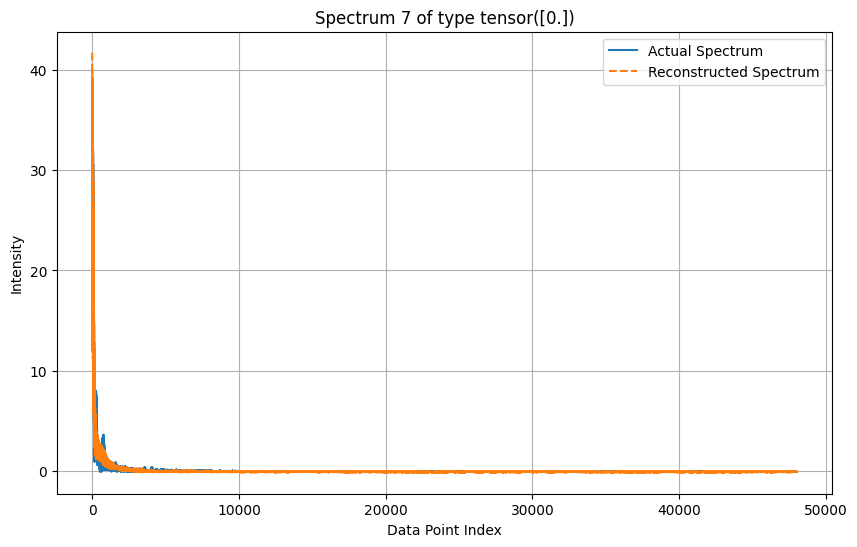

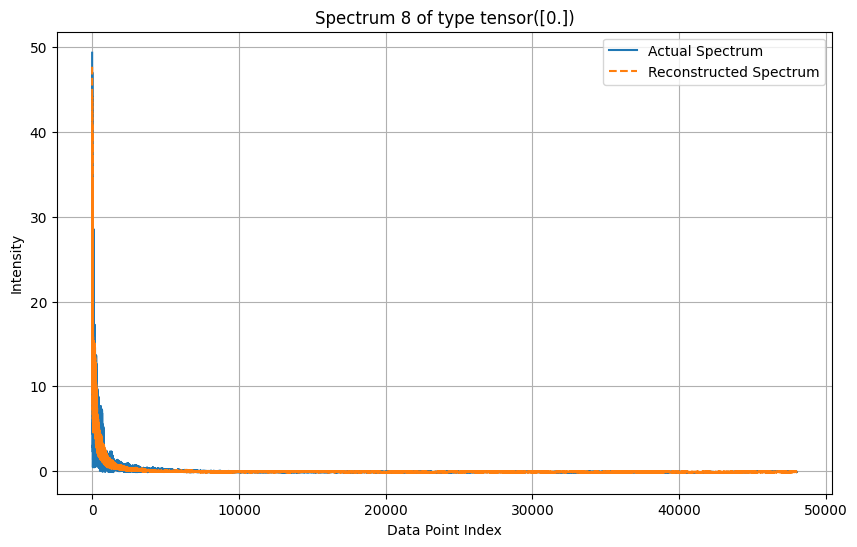

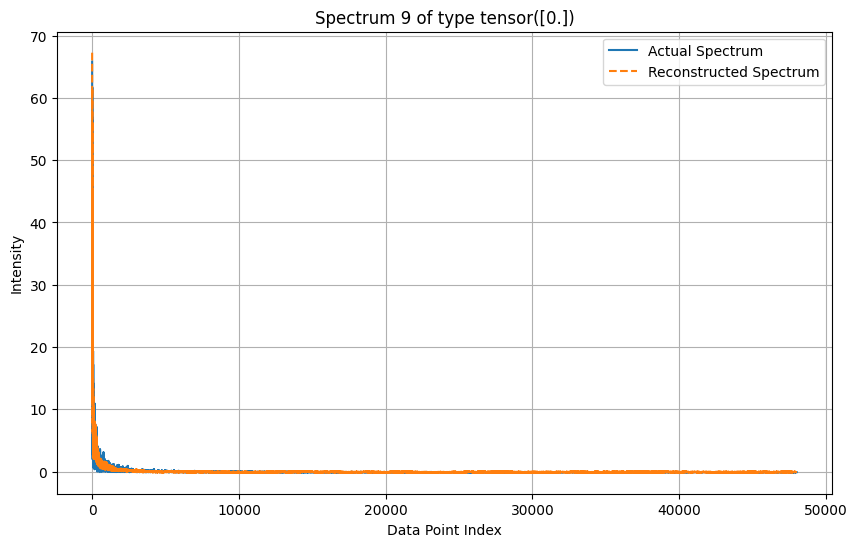

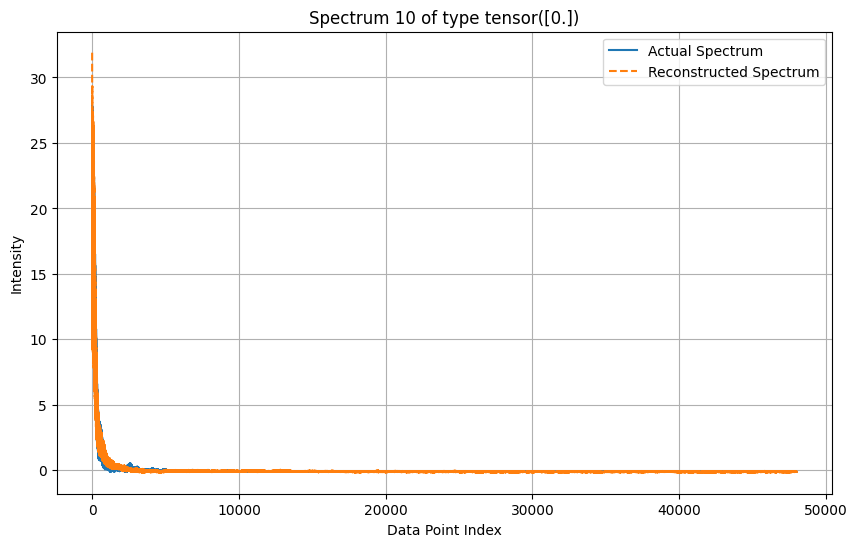

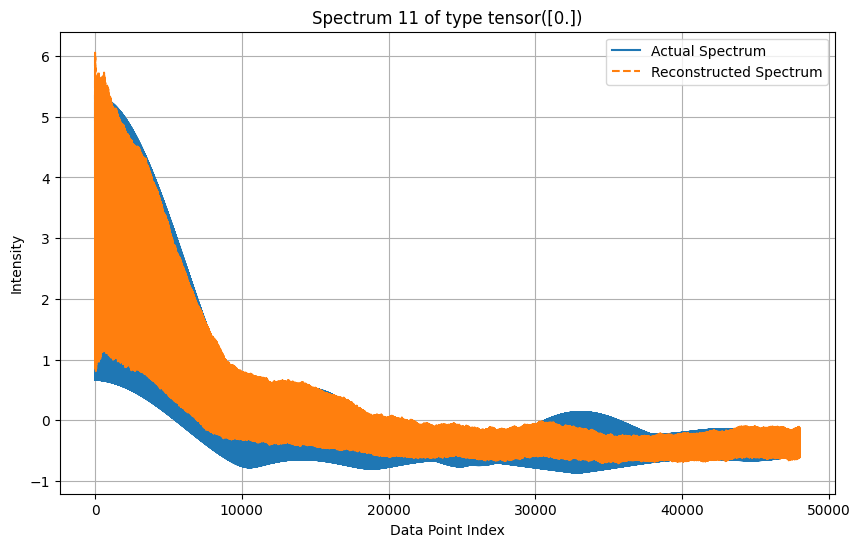

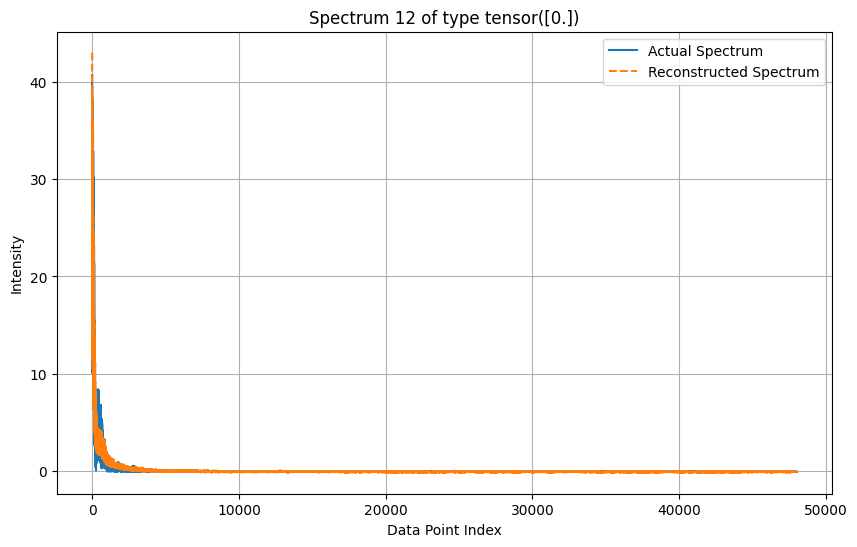

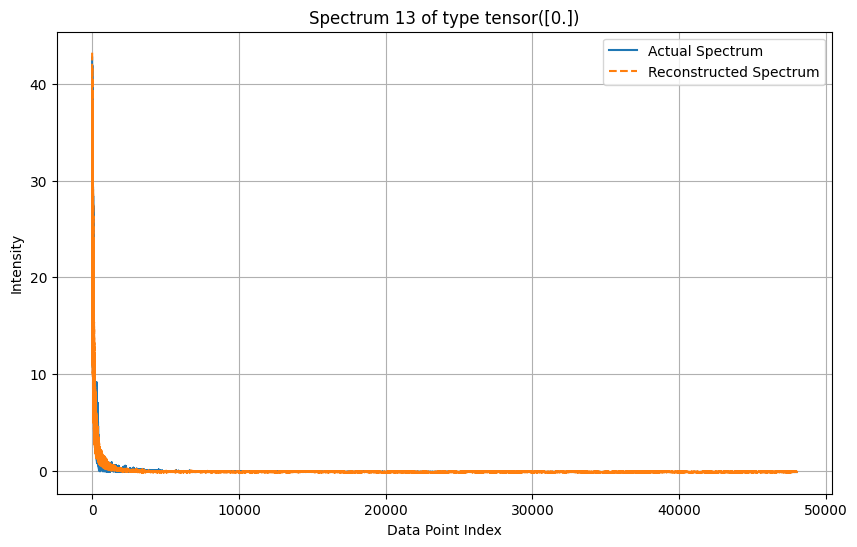

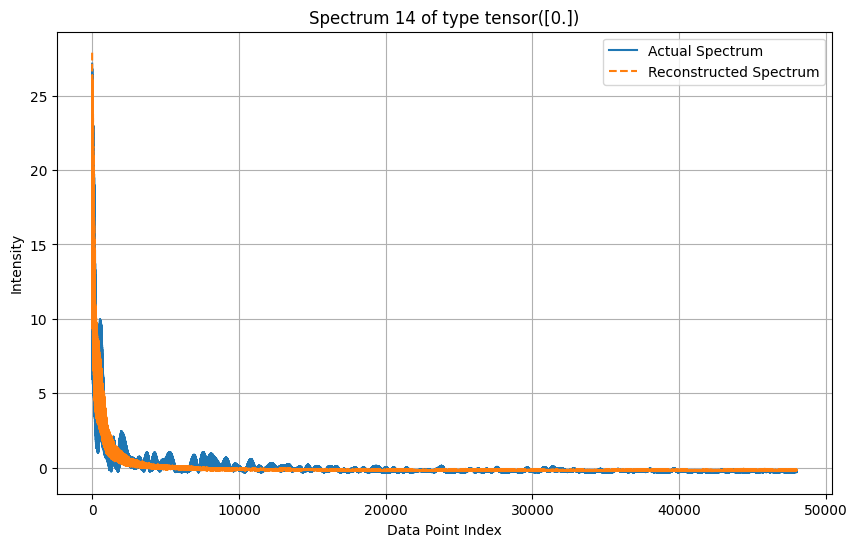

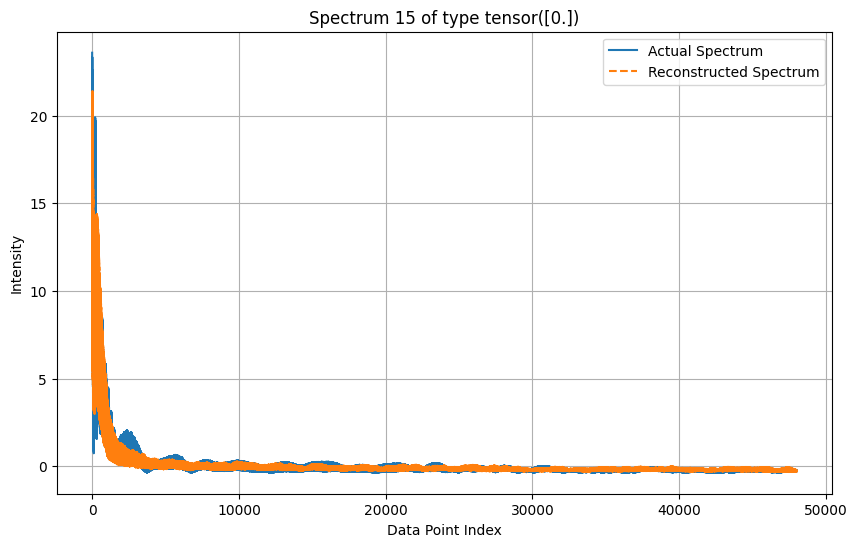

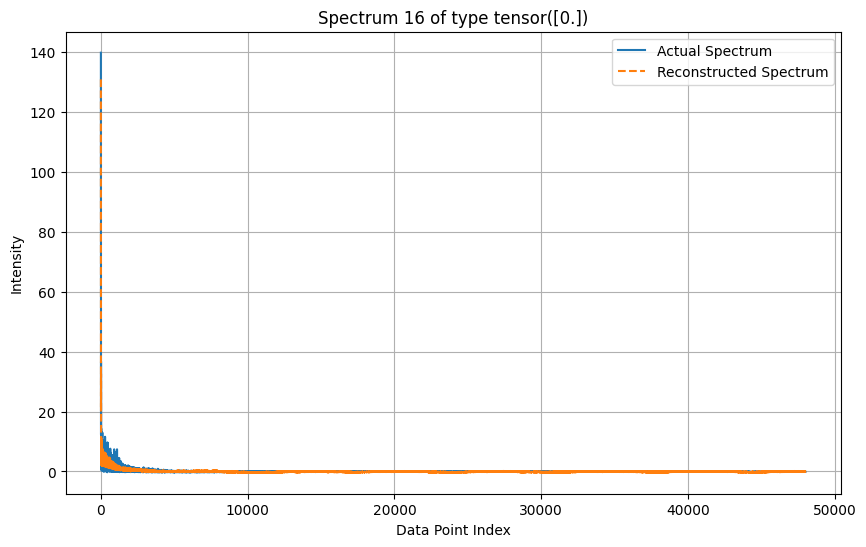

In [30]:
vis_loader = DataLoader(test_dataset, batch_size=16, shuffle=True) # get 16 random spectra

for X_batch, y_batch in vis_loader:
    # Simulated x-axis values for the spectrum
    x = np.linspace(0, features.shape[1], features.shape[1])
    
    with torch.no_grad():
        preds = AE(X_batch).detach()
    
    for i in range(len(X_batch)):
        plt.figure(figsize=(10, 6))
        plt.plot(x, X_batch[i].numpy(), label='Actual Spectrum')  # Converting tensor to numpy array for plotting
        plt.plot(x, preds[i].numpy(), label='Reconstructed Spectrum',linestyle='--')
        plt.title(f'Spectrum {i+1} of type {y_batch[i]}')
        plt.xlabel('Data Point Index')
        plt.ylabel('Intensity')
        plt.legend()
        plt.grid(True)
    break # just need one batch of 16

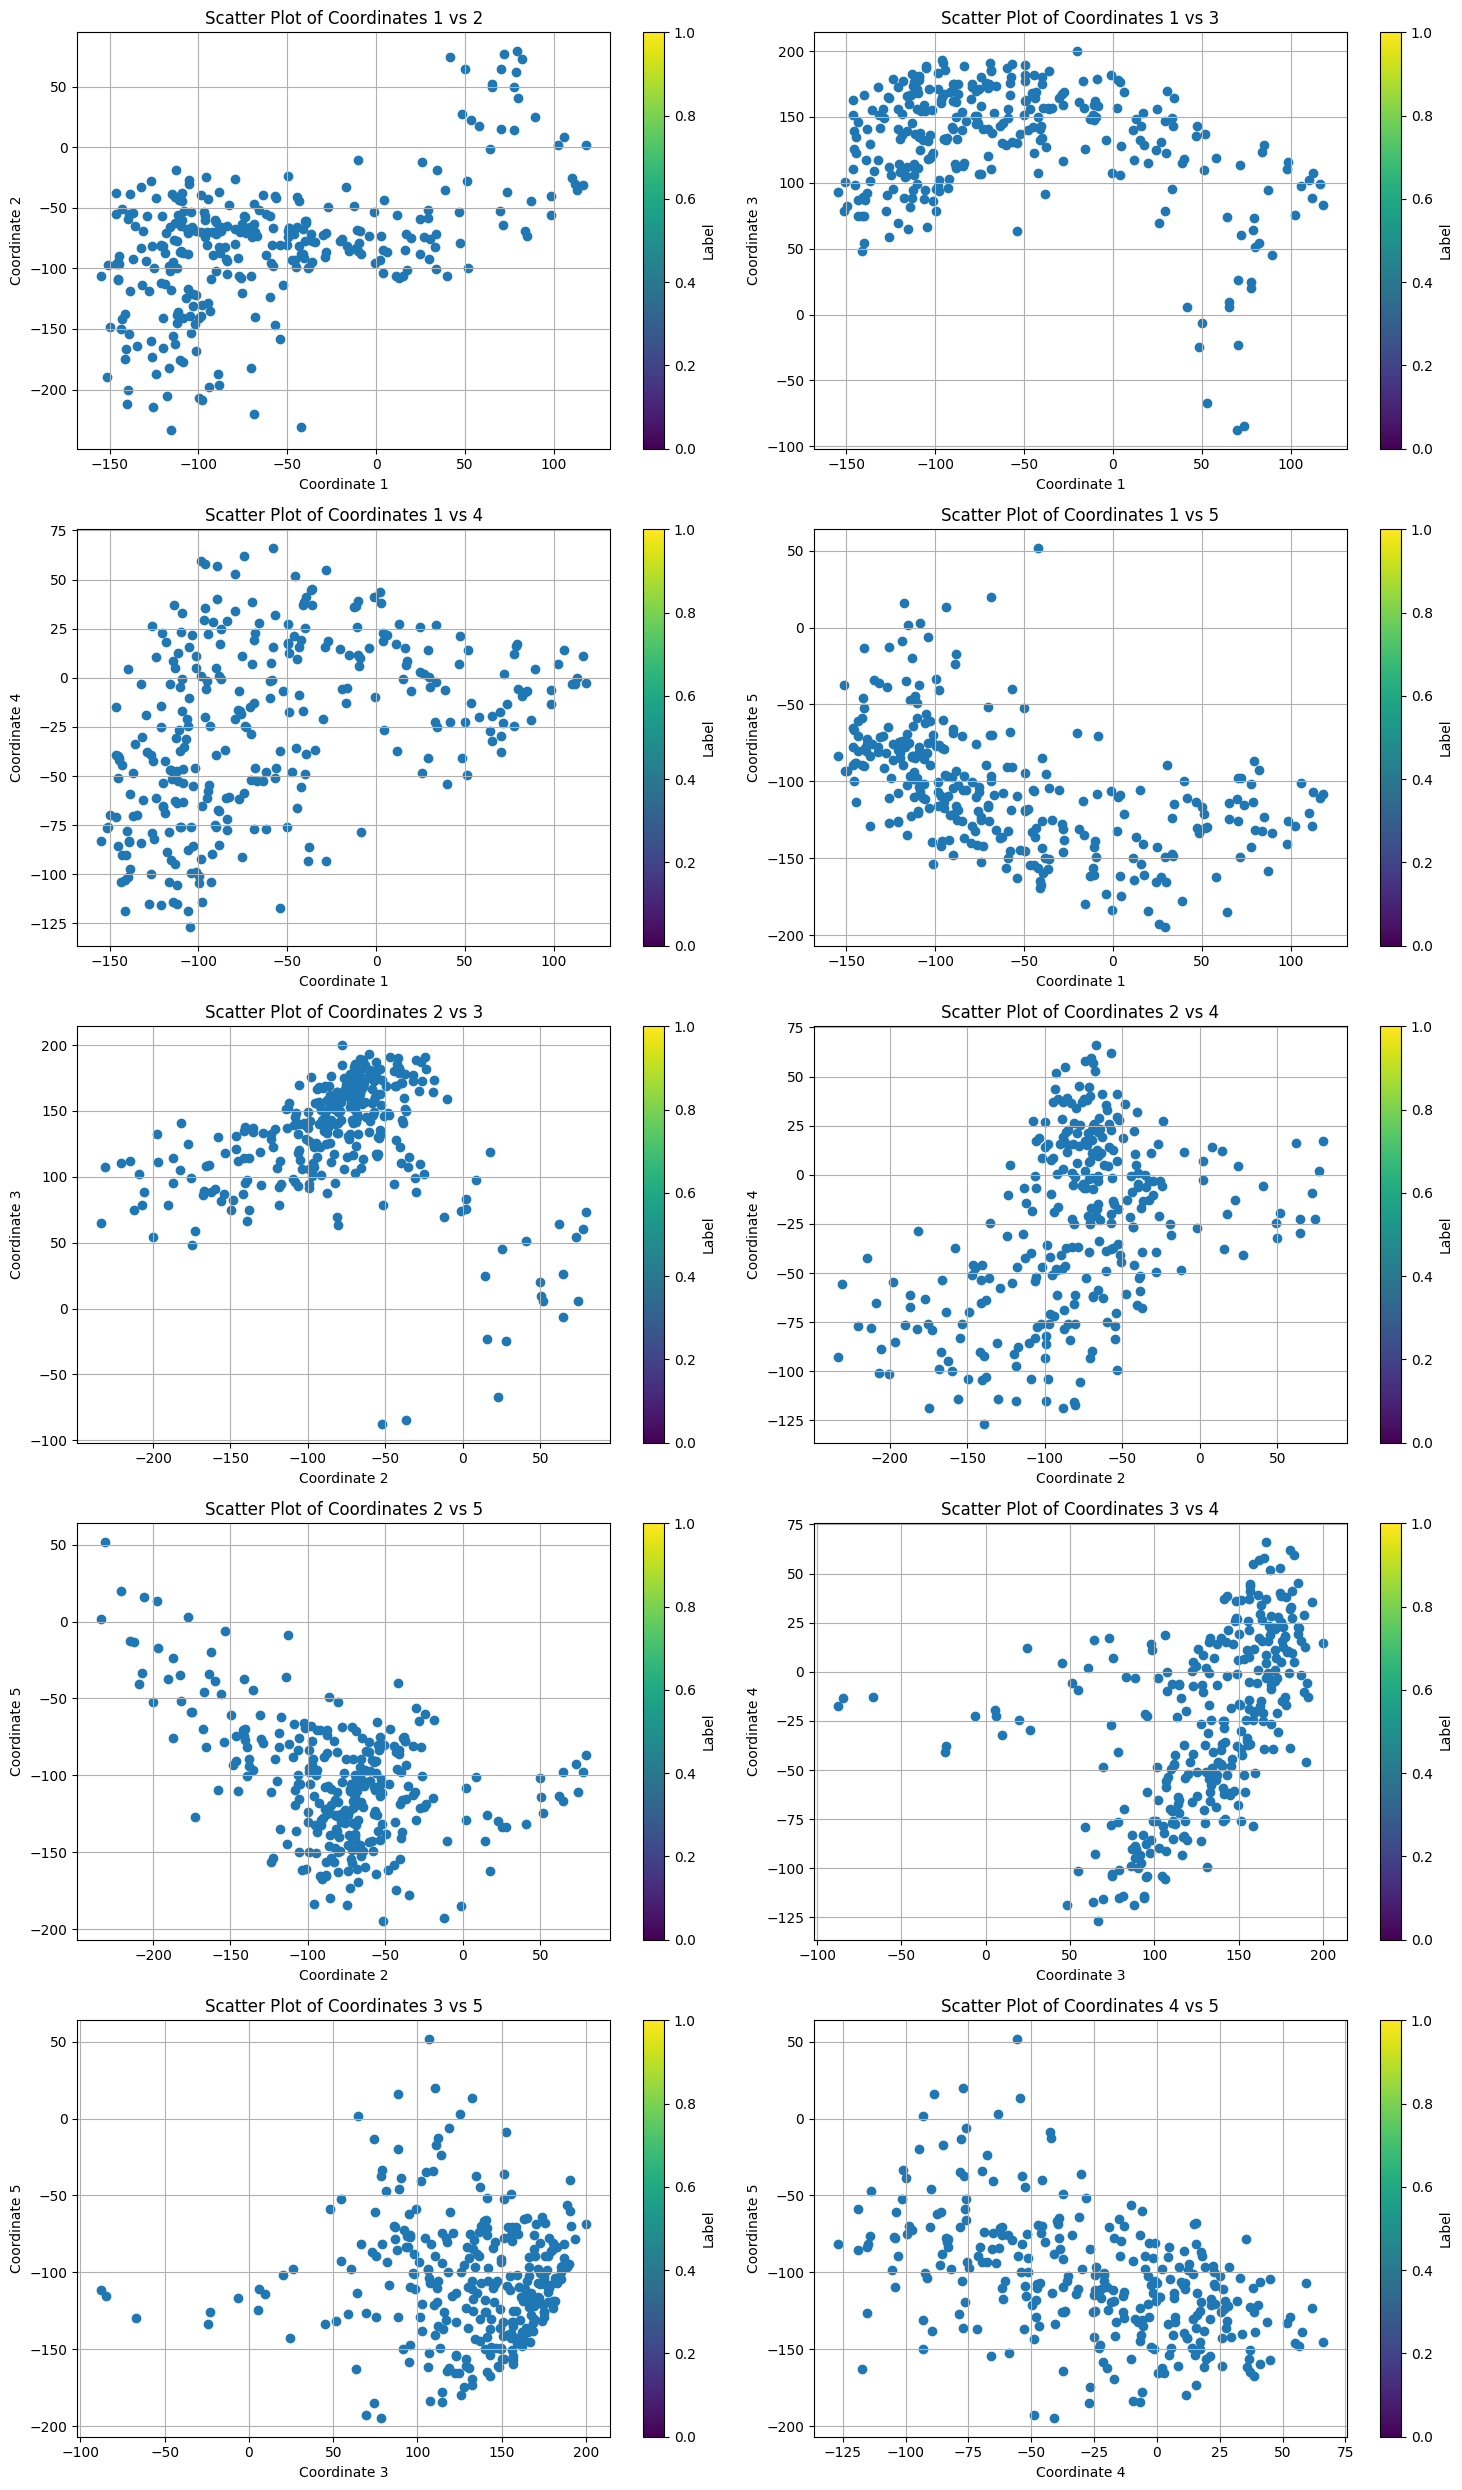

In [31]:
preds = []
labls = []
for X_batch, y_batch in test_dataloader:
    with torch.no_grad():
        preds.append(AE.encoder(X_batch).detach())
        labls += y_batch

preds = torch.cat(preds)

import itertools

# Assuming `preds` is your 5-dimensional encoded tensor
# Example: preds = torch.randn(100, 5)  # Random data for illustration

# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(itertools.combinations(range(5), 2))

# Create plots for all combinations
fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    ax = axs[i//2, i%2]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds[:, idx1].numpy(), preds[:, idx2].numpy())
    ax.set_title(f'Scatter Plot of Coordinates {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Coordinate {idx1+1}')
    ax.set_ylabel(f'Coordinate {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

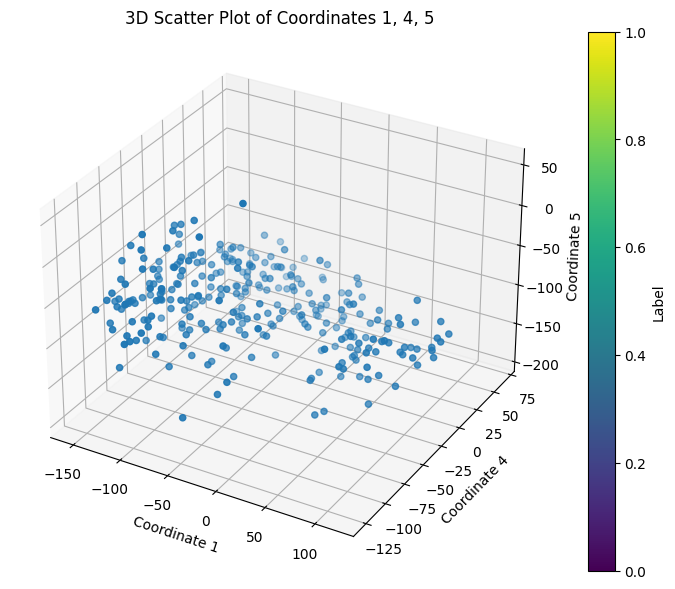

In [32]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot
scatter = ax.scatter(preds[:, 0].numpy(), preds[:, 3].numpy(), preds[:, 4].numpy())

# Add labels and title
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 4')
ax.set_zlabel('Coordinate 5')
ax.set_title('3D Scatter Plot of Coordinates 1, 4, 5')

# Add a color bar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Label')

plt.show()

In [33]:
preds_=preds

In [34]:
from sklearn.cluster import KMeans

encoded = preds_
kmeans = KMeans(n_clusters=2, random_state=205).fit(encoded)
kmeans

KMeans(n_clusters=2, random_state=205)

In [35]:
print(kmeans.cluster_centers_)

[[ -99.00337888  -97.50330656  137.44201435  -40.18977557  -88.73198346]
 [  23.57491111  -45.58461077  115.02753862    3.36663619 -136.87437348]]


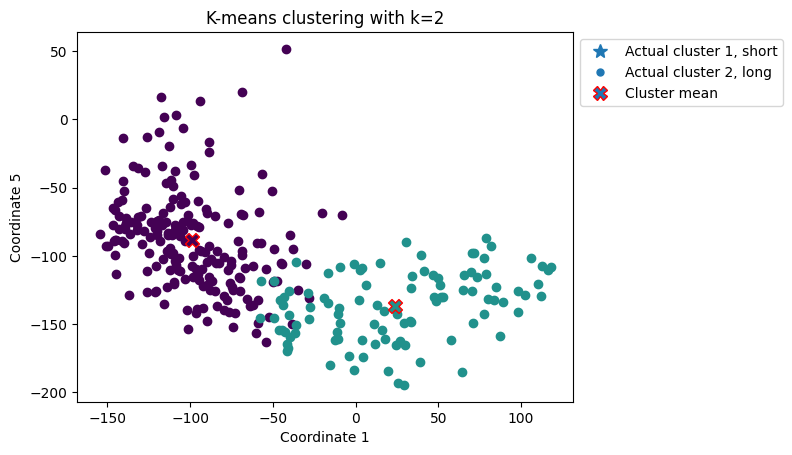

In [36]:
from matplotlib.lines import Line2D      

ax = plt.subplot(1,1,1)
labls_array = np.array([label.item() for label in labls])
description = ['short','long']

# Use the viridis colormap
colormap = plt.cm.viridis

num_classes = len(description)

# Normalize label values to match the colormap range
normalize = plt.Normalize(vmin=0, vmax=num_classes)

markers = ['*', '.']


for pred_class in range(num_classes):
    total_mask = kmeans.labels_ == pred_class
    ax.scatter(encoded[total_mask,0], encoded[total_mask,4], 
               color=colormap(normalize(pred_class)))

# cluster center
for idx, center in enumerate(kmeans.cluster_centers_):
    ax.scatter(center[0],center[4], color=colormap(normalize(idx)), marker='X', s=100, edgecolors='red')
    
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 5')
ax.set_title("K-means clustering with k=2")
legend_elements = [Line2D([0], [0], marker=markers[i-1], linewidth=0, label=f'Actual cluster {i}, {description[i-1]}',
                           markersize=10) for i in range(1, num_classes+1)]
legend_elements.append(Line2D([0], [0], marker='X', linewidth=0, label=f'Cluster mean',
                           markersize=10,markeredgecolor='red'))
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [66]:
bat = []
for X_batch, y_batch in test_dataloader:
    bat.append(X_batch)

bat = torch.concat(bat)
bat

tensor([[40.1749, 16.7267, 15.0957,  ..., -0.3035, -0.3028, -0.3253],
        [46.4098, 15.9915, 20.7608,  ..., -0.0975, -0.0963, -0.0983],
        [47.7625, 13.2855, 22.6663,  ..., -0.0734, -0.0745, -0.0761],
        ...,
        [49.1908, 23.6517, 19.0668,  ..., -0.1298, -0.1305, -0.1185],
        [21.9737,  9.7799,  8.0182,  ..., -0.1564, -0.1566, -0.1591],
        [33.2629,  9.2382, 15.8533,  ..., -0.1633, -0.1630, -0.2062]])

In [70]:
torch.mean(bat[:,0])

tensor(37.3010)

In [72]:
bat2 = []
for X_batch, y_batch in train_dataloader:
    bat2.append(X_batch)

bat2 = torch.concat(bat2)
bat2

tensor([[ 5.4782,  1.1106,  2.8355,  ..., -0.5524, -0.5523, -0.4286],
        [56.5584, 21.2851, 23.2672,  ..., -0.1070, -0.1062, -0.1079],
        [54.1489, 17.1386, 24.7807,  ..., -0.1068, -0.1108, -0.1068],
        ...,
        [69.7134, 21.3917, 32.1779,  ..., -0.0783, -0.0787, -0.0790],
        [20.6788,  8.1145,  9.1288,  ..., -0.2942, -0.2939, -0.2641],
        [24.0263,  8.5750, 10.8825,  ..., -0.1952, -0.1952, -0.2027]])

In [73]:
torch.mean(bat2[:,0])

tensor(38.0576)

In [ ]:
preds2 = []
for x in features:
    with torch.no_grad():
        # Convert x from a NumPy array to a PyTorch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)
        
        # Add a batch dimension to x
        x_tensor = x_tensor.unsqueeze(0)
        preds2.append(AE.encoder(x_tensor).detach())

preds2 = torch.cat(preds2)
preds2

In [56]:
for X_batch, y_batch in test_dataloader:
    with torch.no_grad():
        print(X_batch.shape)
        print(AE.encoder(X_batch).detach())
        # preds.append(AE.encoder(X_batch).detach())
        # labls += y_batch

torch.Size([256, 48000])
tensor([[ -68.9201, -220.4692,  110.2581,  -77.0193,   19.8308],
        [ -94.9359,  -80.4771,  132.9096,  -61.1900, -117.5937],
        [  87.2734,  -44.7200,   94.7281,  -21.2828, -158.5168],
        ...,
        [-104.0790, -153.5225,  118.4543,  -75.9033,   -6.1108],
        [  58.0202,   17.6499,  118.5879,  -19.7429, -161.9339],
        [-129.4383,  -94.0111,  156.0476,  -18.9752,  -70.8202]])
torch.Size([45, 48000])
tensor([[ -88.8957, -187.0959,  114.1188,  -67.4537,  -23.5952],
        [-104.3438,  -53.7340,  131.3904,  -99.5522,  -75.1853],
        [-131.3736,  -69.0174,  141.5146,  -62.3615,  -71.2878],
        [-125.8547, -214.7058,  112.0655,  -42.3093,  -12.7779],
        [ -28.0974,  -86.7183,  158.8454,   54.7759, -146.2725],
        [-121.2172, -112.4367,  156.0571,  -14.3579,  -79.4088],
        [ -90.7916,  -59.9764,  141.9911,  -74.7917,  -96.8581],
        [ -10.8606,  -68.1426,  147.8461,   26.0142, -161.0785],
        [  -0.7930,  -95.89

In [60]:
for X, y_batch in test_dataset:
    with torch.no_grad():
        # Convert x from a NumPy array to a PyTorch tensor
        x_tensor = torch.tensor(X, dtype=torch.float32)
        
        # Add a batch dimension to x
        x_tensor = x_tensor.unsqueeze(0)
        print(AE.encoder(x_tensor).detach())
        # print(X_batch.shape)
        # print(AE.encoder(X_batch).detach())

tensor([[  51.5914,  -99.8744,  137.1222,   14.1868, -130.0986]])
tensor([[ -39.9784,  -77.0738,  174.9819,   25.5793, -126.0434]])
tensor([[-96.0928, -60.3791, 193.5009,  35.2953, -78.3196]])
tensor([[  98.2338,  -39.9965,  110.2566,   -6.3127, -141.0591]])
tensor([[   3.8958,  -84.9703,  176.5550,   23.0464, -108.6177]])
tensor([[-107.1723, -124.1536,  132.1361,  -31.3596, -110.7338]])
tensor([[ -87.7045,  -87.5396,  133.0308,   17.3004, -124.8558]])
tensor([[-49.2531, -66.3606, 189.6333,  12.7526, -94.7641]])
tensor([[ -38.3633,  -99.6629,   91.4064,  -93.2268, -149.9134]])
tensor([[  25.9420,  -12.4417,   69.6628,  -48.7049, -193.0573]])
tensor([[-121.2035,  -81.4614,   69.5867, -115.4177, -126.6475]])
tensor([[-138.6850,  -38.7122,  140.9939,  -59.1911,  -75.9854]])
tensor([[ -44.6748,  -65.9197,  181.9209,    9.7408, -105.9969]])
tensor([[-131.7895, -113.9569,  151.4725,  -30.1103,  -35.7941]])
tensor([[-69.0318, -46.8070, 191.1793, -13.0472, -69.6023]])
tensor([[  30.0380,  -91.

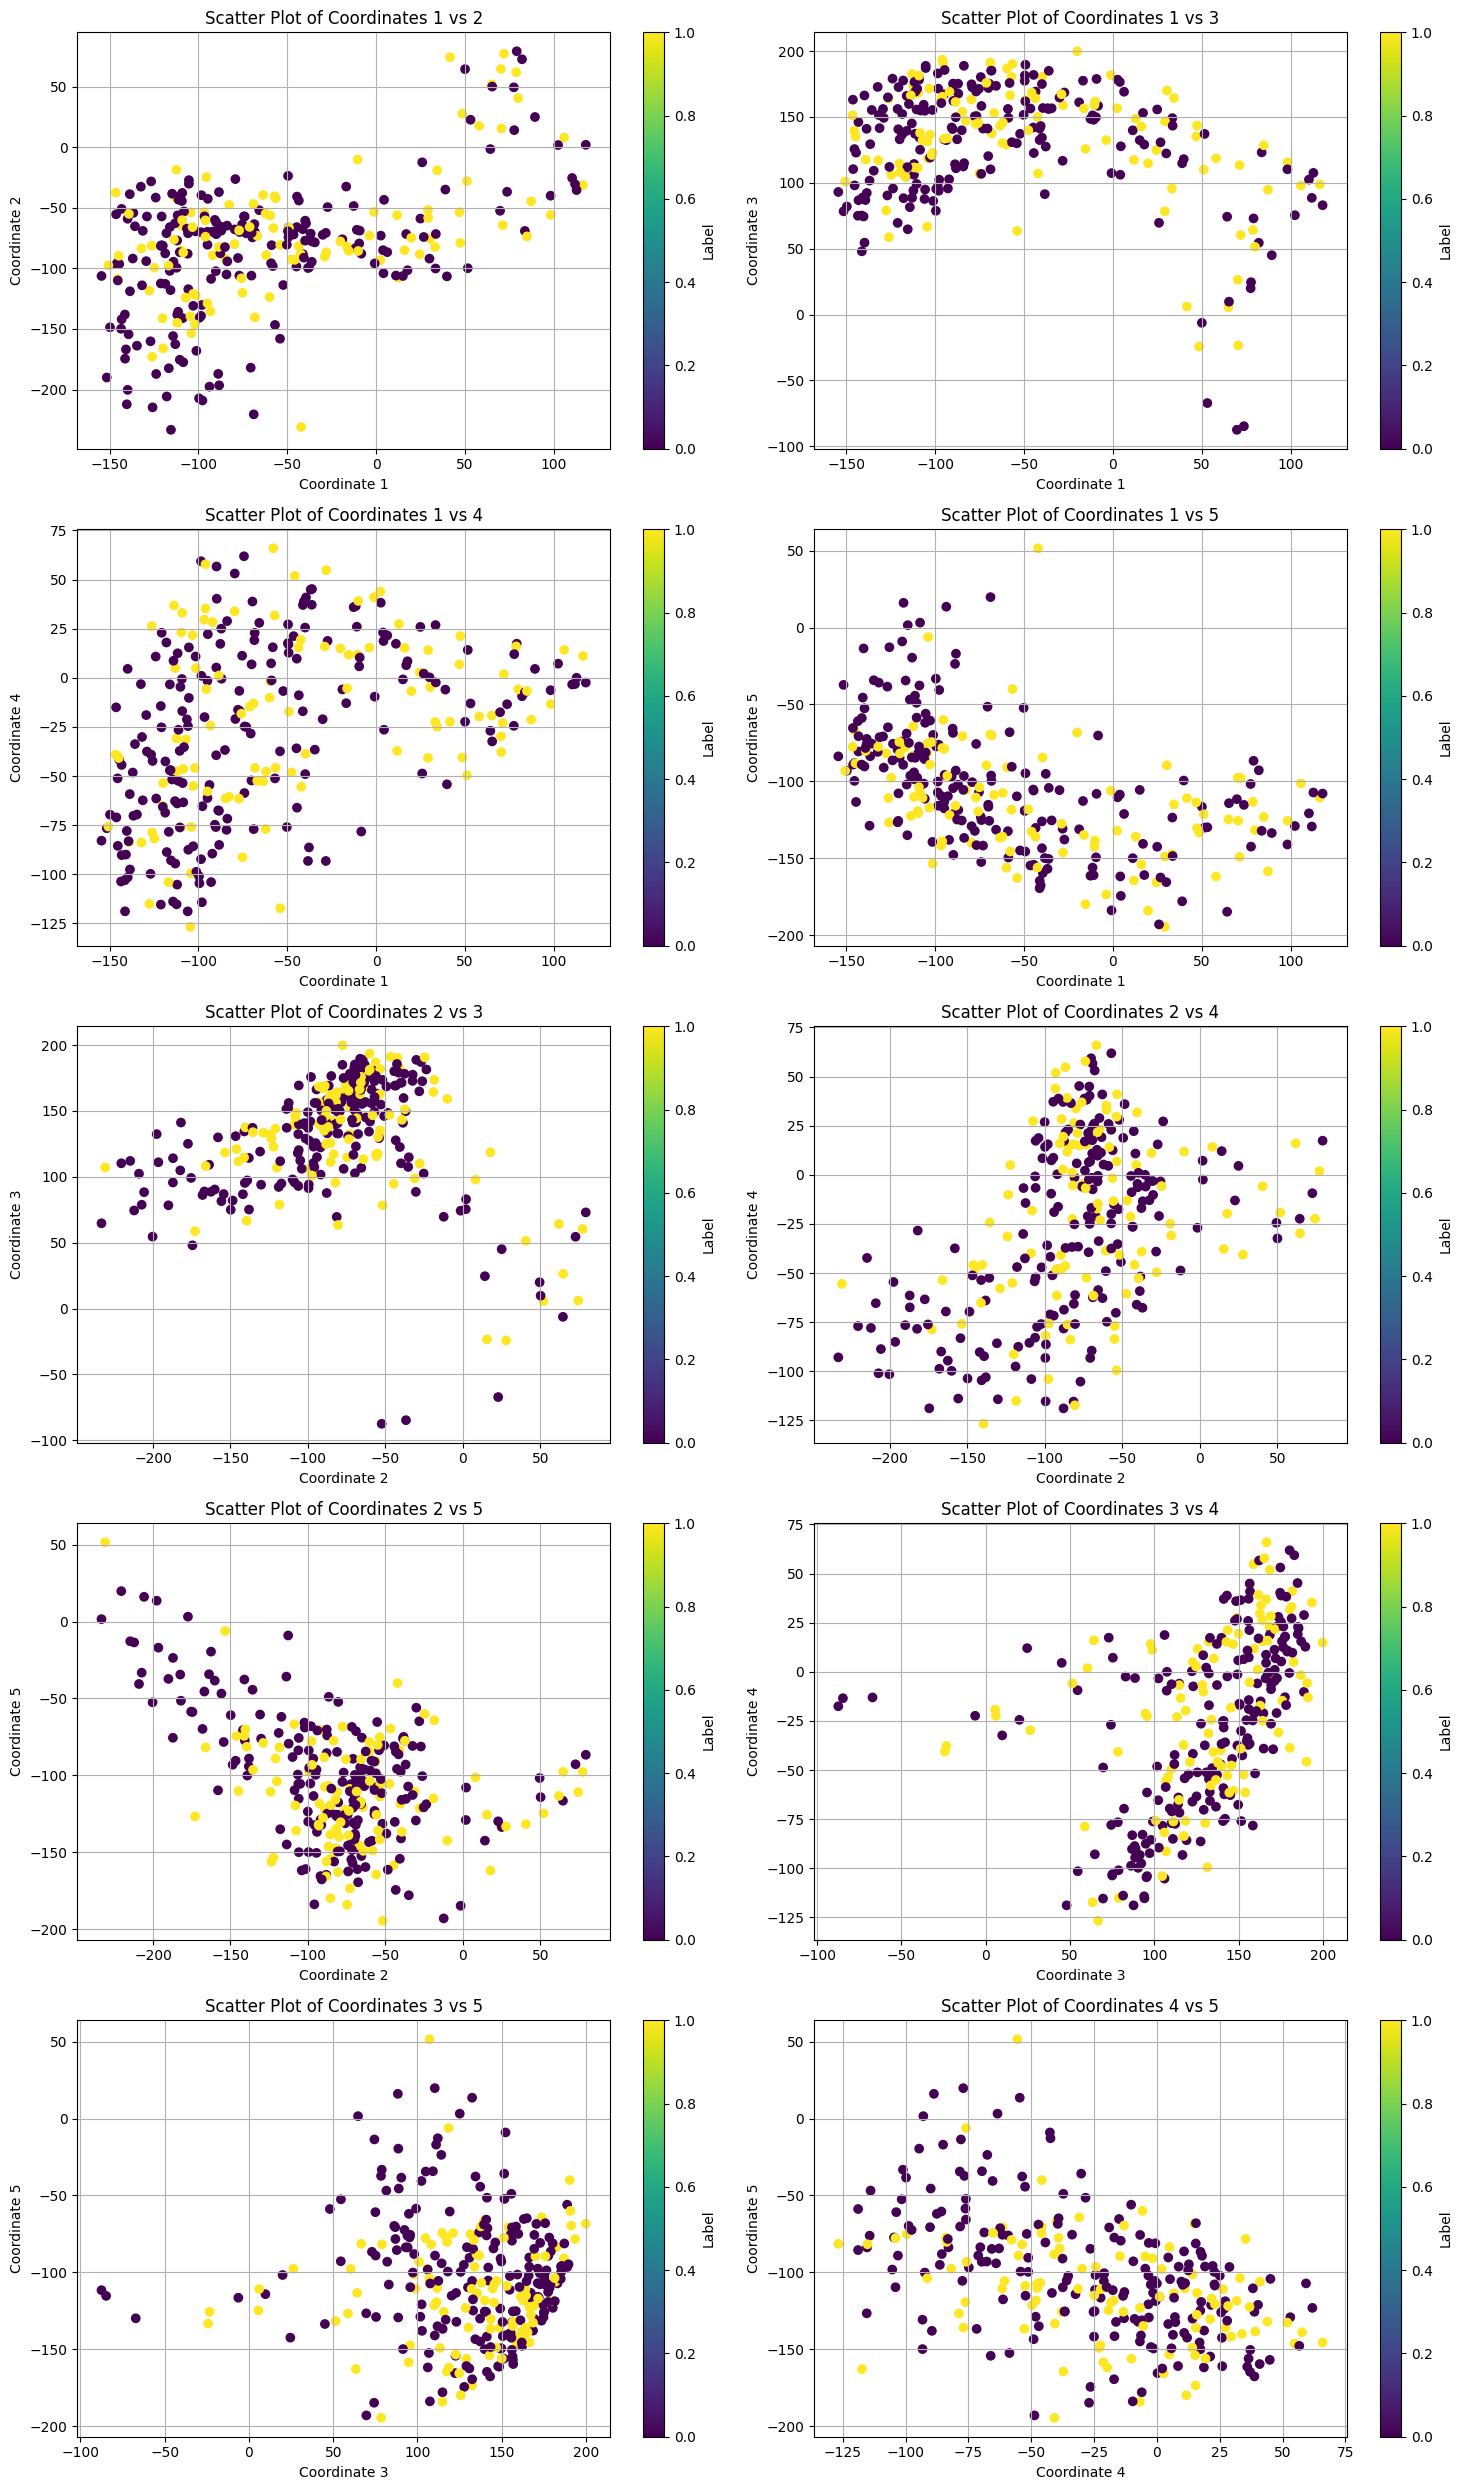

In [37]:
preds = []
labls = []
for X_batch, y_batch in test_dataloader:
    with torch.no_grad():
        preds.append(AE.encoder(X_batch).detach())
        labls += y_batch

preds = torch.cat(preds)

import itertools

# Assuming `preds` is your 5-dimensional encoded tensor
# Example: preds = torch.randn(100, 5)  # Random data for illustration

# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(itertools.combinations(range(5), 2))

# Create plots for all combinations
fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    ax = axs[i//2, i%2]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds[:, idx1].numpy(), preds[:, idx2].numpy(), c=kmeans.labels_, cmap='viridis')
    ax.set_title(f'Scatter Plot of Coordinates {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Coordinate {idx1+1}')
    ax.set_ylabel(f'Coordinate {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

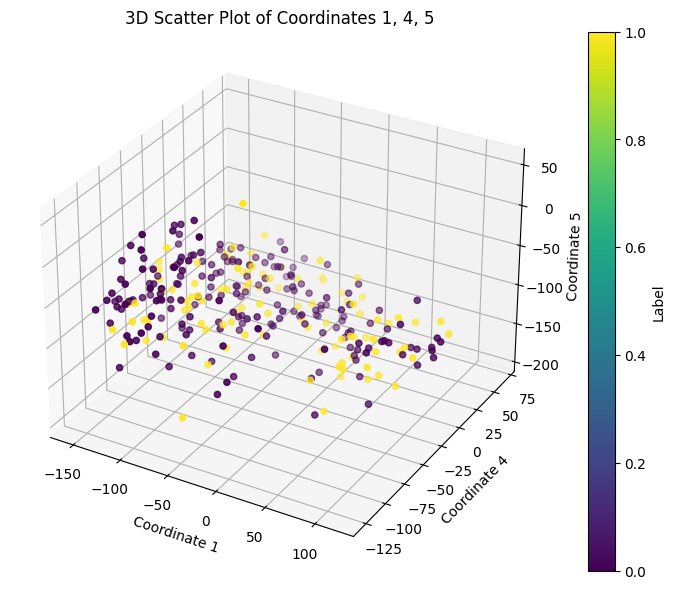

In [38]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot
scatter = ax.scatter(preds[:, 0].numpy(), preds[:, 3].numpy(), preds[:, 4].numpy(), c=kmeans.labels_, cmap='viridis')

# Add labels and title
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 4')
ax.set_zlabel('Coordinate 5')
ax.set_title('3D Scatter Plot of Coordinates 1, 4, 5')

# Add a color bar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Label')

plt.show()

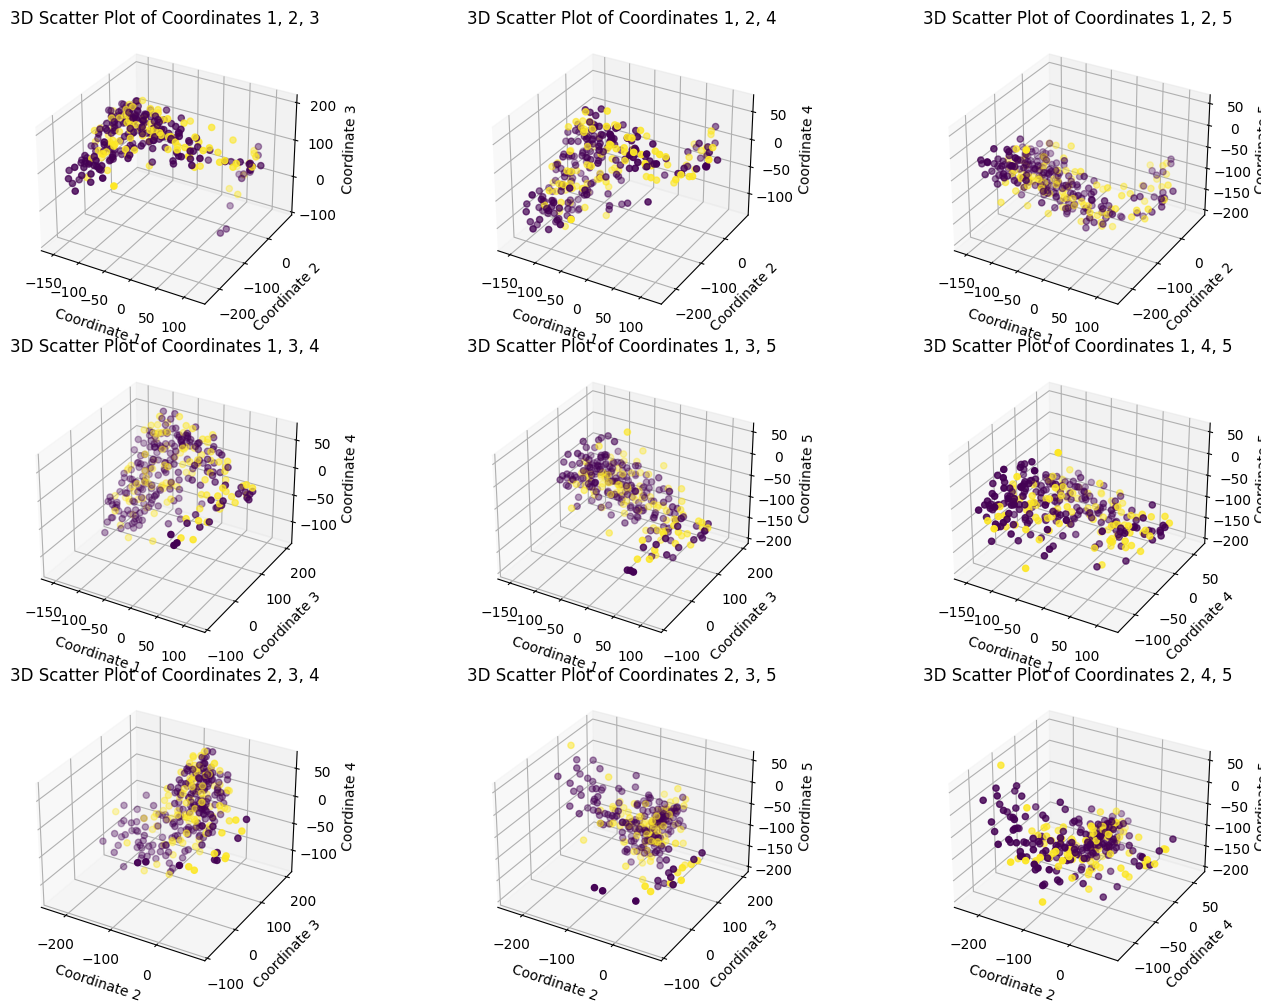

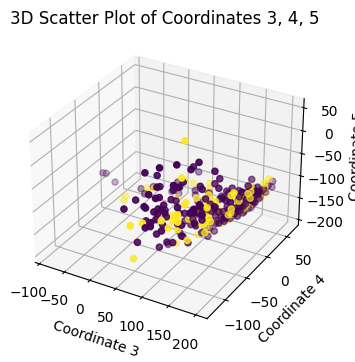

In [52]:
from itertools import combinations

# Get all permutations of three columns out of five (0-based indices)
perms = list(combinations(range(5), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                scatter = ax.scatter(preds[:, x], preds[:, y], preds[:, z], c=kmeans.labels_, cmap='viridis')
                ax.set_xlabel(f'Coordinate {x+1}')
                ax.set_ylabel(f'Coordinate {y+1}')
                ax.set_zlabel(f'Coordinate {z+1}')
                ax.set_title(f'3D Scatter Plot of Coordinates {x+1}, {y+1}, {z+1}')

        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure

In [39]:
features

array([[3.27656018e-04, 8.90758136e-05, 1.61375288e-04, ...,
        1.73956208e-07, 1.70693101e-07, 2.93644213e-08],
       [3.26511273e-04, 1.20652321e-04, 1.46298161e-04, ...,
        5.07940582e-07, 5.08400402e-07, 3.93925527e-07],
       [3.22805695e-04, 1.15998397e-04, 1.47412173e-04, ...,
        7.72965376e-07, 7.72221703e-07, 7.00046130e-07],
       ...,
       [3.25546155e-04, 1.01493401e-04, 1.52078664e-04, ...,
        3.64718902e-08, 3.63834747e-08, 1.90257326e-08],
       [3.29446297e-04, 9.85299455e-05, 1.58399604e-04, ...,
        5.50000709e-07, 5.49733070e-07, 1.69841220e-06],
       [3.26011634e-04, 1.04861078e-04, 1.45344526e-04, ...,
        1.88213509e-07, 1.87953613e-07, 3.16809506e-07]])

In [74]:
preds2 = []
for x in normalized_features:
    with torch.no_grad():
        # Convert x from a NumPy array to a PyTorch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)
        
        # Add a batch dimension to x
        x_tensor = x_tensor.unsqueeze(0)
        preds2.append(AE.encoder(x_tensor).detach())

preds2 = torch.cat(preds2)
preds2

tensor([[ -21.0105,  -90.5401,  136.2059,   23.7522, -172.3225],
        [ -64.7470,  -71.7276,  173.8533,   50.7058, -132.0981],
        [  30.9080,  -69.5658,  144.3163,   14.2155, -152.0453],
        ...,
        [-139.8951,  -59.0221,  166.3147,    4.5492,  -90.3376],
        [  83.1006,  -56.9180,  116.3405,   -9.2507, -145.6755],
        [ -75.9289,  -44.2435,  190.7046,   18.2061,  -91.9214]])

In [75]:
encoded2 = preds2
kmeans2 = KMeans(n_clusters=2, random_state=205).fit(encoded2)
kmeans2

KMeans(n_clusters=2, random_state=205)

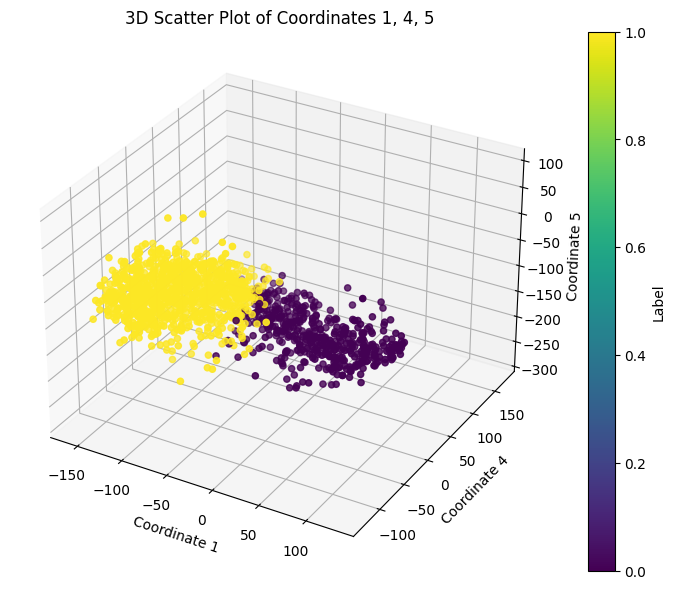

In [76]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot
scatter = ax.scatter(preds2[:, 0].numpy(), preds2[:, 3].numpy(), preds2[:, 4].numpy(), c=kmeans2.labels_, cmap='viridis')

# Add labels and title
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 4')
ax.set_zlabel('Coordinate 5')
ax.set_title('3D Scatter Plot of Coordinates 1, 4, 5')

# Add a color bar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Label')

plt.show()

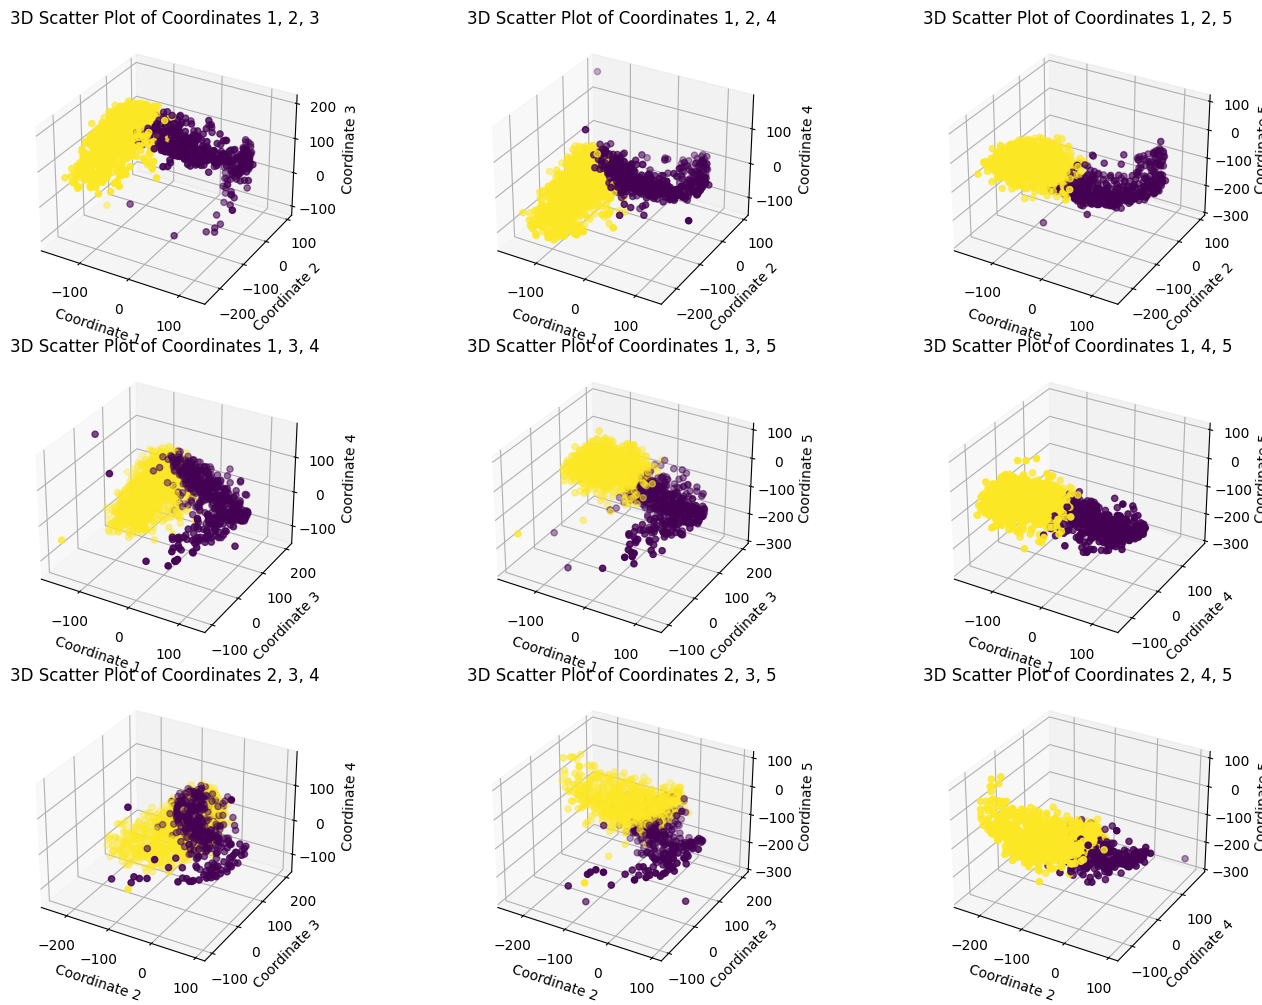

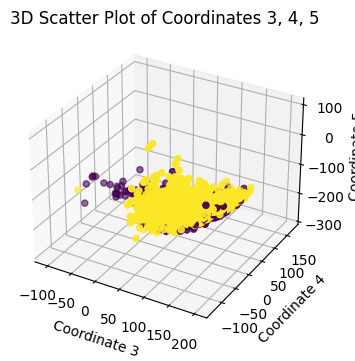

In [77]:
# Get all permutations of three columns out of five (0-based indices)
perms = list(combinations(range(5), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=kmeans2.labels_, cmap='viridis')
                ax.set_xlabel(f'Coordinate {x+1}')
                ax.set_ylabel(f'Coordinate {y+1}')
                ax.set_zlabel(f'Coordinate {z+1}')
                ax.set_title(f'3D Scatter Plot of Coordinates {x+1}, {y+1}, {z+1}')

        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure

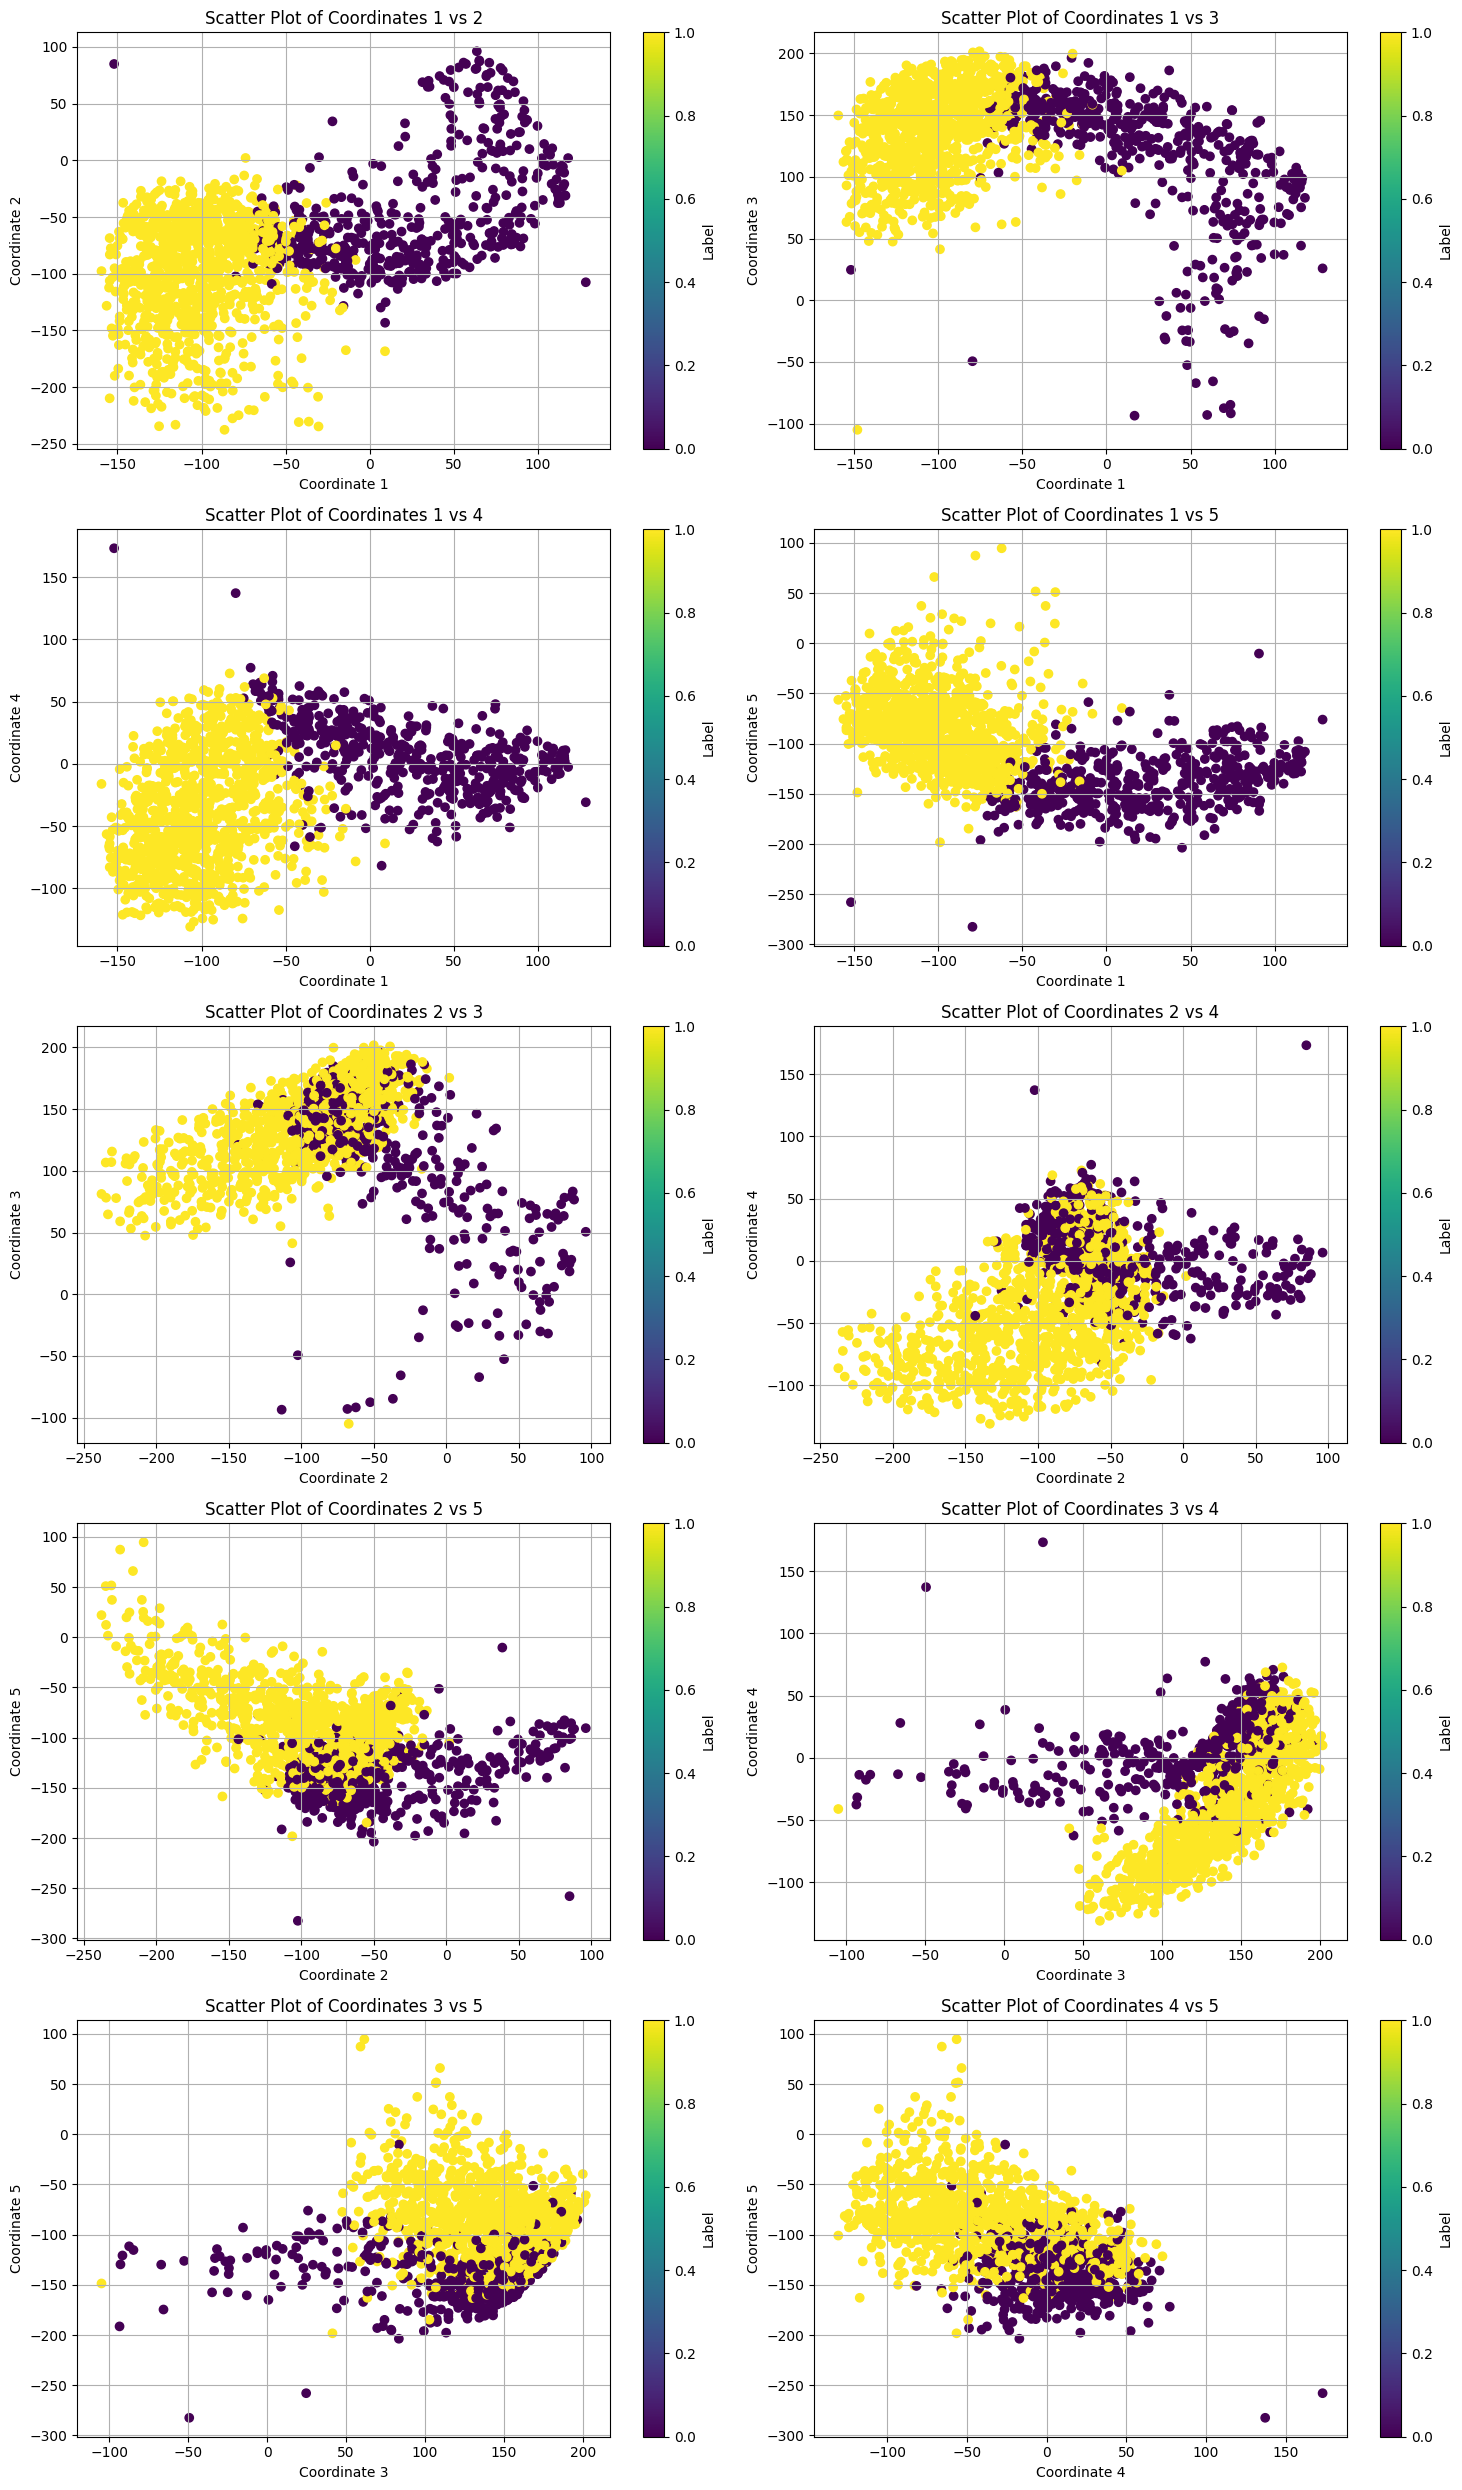

In [78]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(itertools.combinations(range(5), 2))

# Create plots for all combinations
fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    ax = axs[i//2, i%2]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[:, idx1].numpy(), preds2[:, idx2].numpy(), c=kmeans2.labels_, cmap='viridis')
    ax.set_title(f'Scatter Plot of Coordinates {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Coordinate {idx1+1}')
    ax.set_ylabel(f'Coordinate {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

In [79]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
names_64ms, features_64ms = data_loaded['names'], data_loaded['data']

Finding Durations: 100%|█████████████████████| 488/488 [00:04<00:00, 99.01GRB/s]


Text(0, 0.5, 'Number of GRBs')

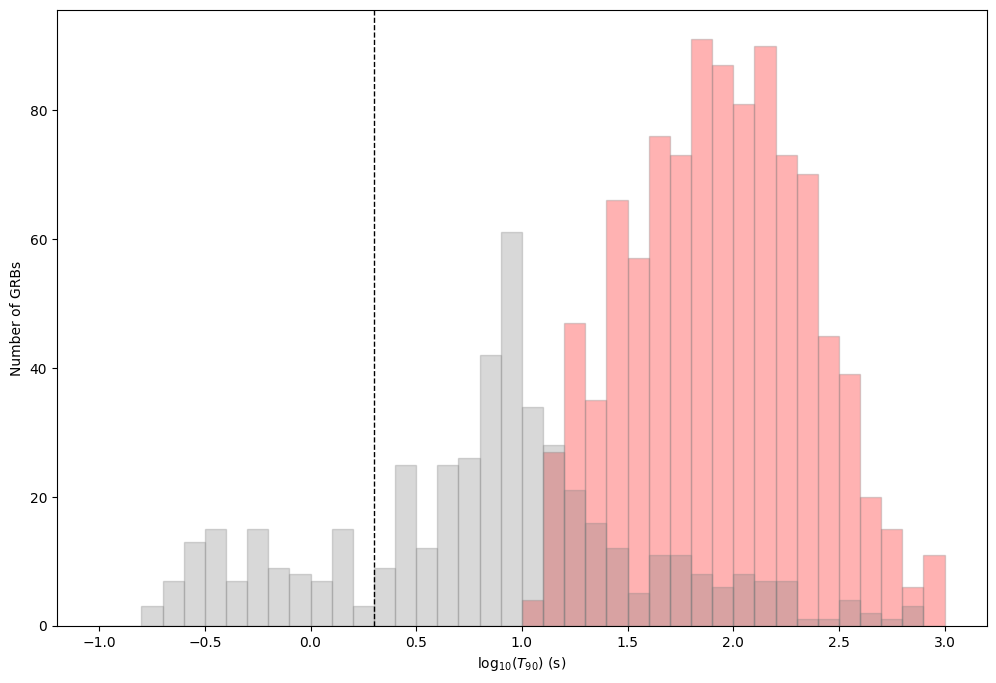

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match = kmeans2.labels_==1
match2 = kmeans2.labels_==0
names1 = names_64ms[match]
names2 = names_64ms[match2]
swift.duration_histogram(names=[names1, names2], alpha=0.3, color_groups=['r', 'gray'], ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')

In [81]:
fname = f'autoencoded_nr_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.pt'
torch.save(preds2, fname)